In [154]:
# Installations
#conda install -c conda-forge librosa
#conda install -c conda-forge ffmpeg
#You may need to restart the kernel (or close the jupyter notebook and restart) after installations

In [135]:
# imports

#General
import numpy as np
import pandas as pd
import itertools
import pickle

# System
import os, fnmatch

# Visualization
import seaborn as sns #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image



# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

# Configurations
path='./data/'

## Load feature vectors and labels

In [55]:
with open('x.pkl', 'rb') as f:
    feature_vectors = pickle.load(f)
with open('y.pkl', 'rb') as f:
    classes_num = pickle.load(f)

## Standardization: Zero-Mean and Unit-Variance

In [56]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (1490, 82)


## Train and Test Sets

In [57]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=42)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [58]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (1117, 82)
test_set shape: (373, 82)
train_classes shape: (1117,)
test_classes shape: (373,)


## Explore significant features: RandomForestRegressor

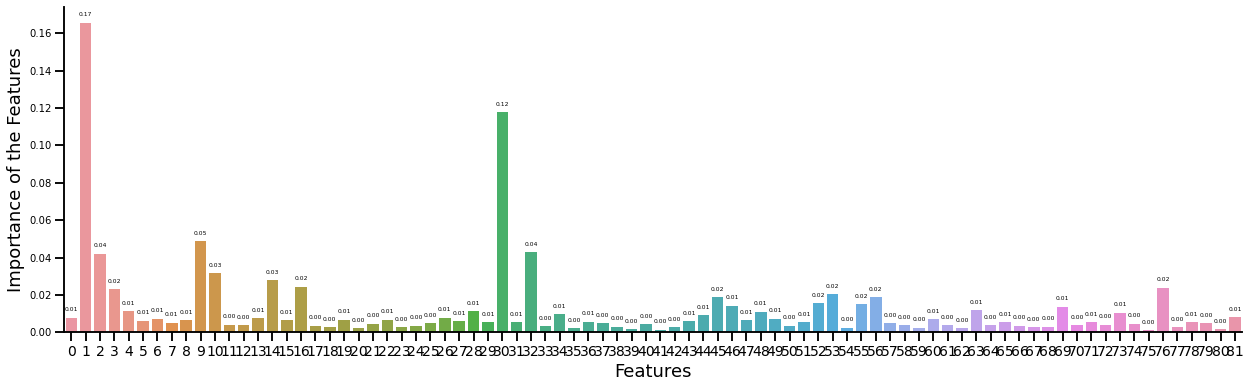

In [60]:
rf = RandomForestRegressor(random_state=0)
rf.fit(train_set,train_classes);
f_i = list(zip(range(0,train_set.shape[1]),rf.feature_importances_))
f_i.sort(key = lambda x : x[1],reverse=True)

sns.set_context("talk", font_scale=1.5)
fig, axis = plt.subplots(figsize=(18, 6))
g=sns.barplot(x=0, y=1 ,data=pd.DataFrame(f_i))

for bar in g.patches:
    g.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=6, xytext=(0, 8),
                   textcoords='offset points')


axis.set_xlabel('Features', fontsize=18)
axis.set_ylabel('Importance of the Features', fontsize=18)
axis.tick_params(axis='x', labelsize=10, )
axis.tick_params(axis='y', labelsize=10)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('bar_im_features.jpg')
plt.show()


## Tuning hyper-parameters for logistic Regression

In [133]:
# Splitting Training set for 10 fold for Cross Validation to set the hypeparameter C in LR
def tuning_c_with_lg(c_values):
    accuracies = []
    accu_std = []
    np.set_printoptions(precision=3)
    for c in c_values:
        # train the LR classifier with the current value of `c`
        model = LogisticRegression(penalty = 'l2',multi_class='ovr', solver='newton-cg', C=c)
        scores = cross_validate(model, train_set, train_classes, cv = 10)
        # evaluate the model accuracy
        mean_score = scores['test_score'].mean()
        std_score = scores['test_score'].std()
        #print("k={}, mean_accuracy={:.2f}% , std_accuracy = {:.3f}".format(k, mean_score*100,std_score))
        accuracies.append(mean_score)
        accu_std.append(std_score)

    c=c_values[np.argmax(accuracies)]
    max_acu= max(accuracies)*100
    print('\nSelected Hyperparameter C in Logistic Regression is {} with accuracy of : {:.2f}'.format(c, max_acu))
    return accuracies,accu_std


Selected Hyperparameter C in Logistic Regression is 0.2 with accuracy of : 92.30


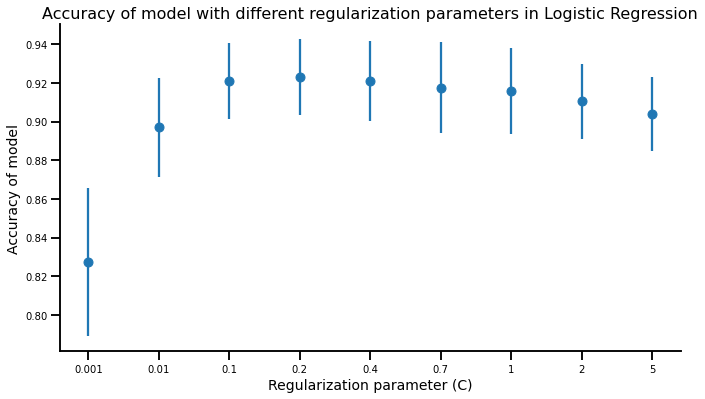

In [153]:
#plot accuracy in c in lr
c_values = [0.001, 0.01, 0.1, 0.2, 0.4, 0.7, 1, 2, 5]
labels= [str(c) for c in c_values]
accuracies,accu_std = tuning_c_with_lg(c_values)

sns.set_context("talk", font_scale=1.2)
fig, axis = plt.subplots(figsize=(10, 6))
axis.errorbar(labels, accuracies, yerr=accu_std, fmt='o')
axis.set_title('Accuracy of model with different regularization parameters in Logistic Regression', fontsize=16)
axis.set_xlabel('Regularization parameter (C)', fontsize=14)
axis.set_ylabel('Accuracy of model', fontsize=14)
axis.tick_params(axis='x', labelsize=10)
axis.tick_params(axis='y', labelsize=10)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('c_in_lg.jpg')
plt.show()

## Logistic Regression Classification

In [158]:
# logistic Regression Classifier
model_lg = LogisticRegression(penalty = 'l2',multi_class='ovr', solver='newton-cg', C=0.1)

In [159]:
# traning logistic Regression
model_lg.fit(train_set, train_classes);

In [160]:
# Predict using the Test Set
predicted_labels = model_lg.predict(test_set)

## Evaluation

In [161]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.969 0.967 0.983 0.864 0.897 0.908]
Precision:  [0.984 0.921 0.952 0.919 0.867 0.937]
F1-Score:  [0.976 0.943 0.967 0.891 0.881 0.922]
Accuracy: 0.93  , 347
Number of samples: 373


In [162]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [163]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

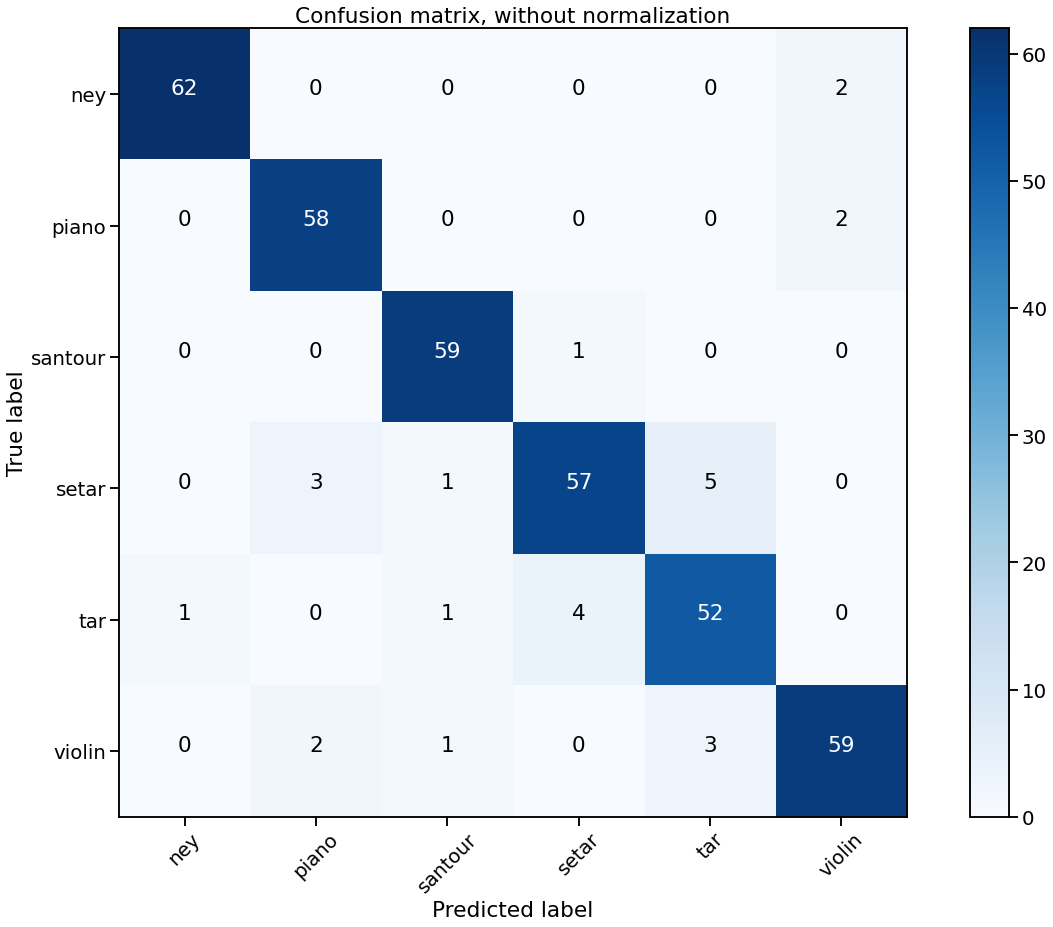

In [165]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')
plt.savefig('cm_lr.jpg')

In [49]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [50]:
 #Find wrong predicted audio files
print('True labels are:')    
print(np.array(labels)[test_index[wrong_predictions]])
#print(predicted_labels[wrong_predictions].T)
print('Predicted labels are:')  
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print('Wrong files are:')
for i, index in enumerate(wrong_predictions):
    print('File #%d:' %i,np.array(files)[test_index[index]])

True labels are:
['violin' 'setar' 'santour' 'santour' 'violin' 'santour' 'tar' 'setar'
 'violin' 'violin' 'violin' 'violin' 'tar' 'ney' 'setar' 'santour' 'setar'
 'santour' 'setar' 'tar' 'setar' 'setar' 'tar' 'setar' 'santour' 'violin'
 'setar' 'santour' 'violin' 'ney' 'violin' 'ney' 'ney' 'setar' 'tar' 'ney'
 'setar' 'setar' 'violin' 'setar' 'ney' 'violin' 'violin' 'santour' 'tar'
 'violin' 'violin' 'setar' 'violin' 'santour']
Predicted labels are:
['ney' 'tar' 'setar' 'tar' 'setar' 'piano' 'setar' 'tar' 'ney' 'ney' 'ney'
 'tar' 'setar' 'violin' 'violin' 'tar' 'violin' 'tar' 'tar' 'setar'
 'violin' 'santour' 'santour' 'violin' 'setar' 'tar' 'santour' 'ney'
 'santour' 'violin' 'ney' 'violin' 'setar' 'tar' 'setar' 'piano' 'tar'
 'tar' 'piano' 'violin' 'violin' 'tar' 'setar' 'tar' 'violin' 'piano'
 'tar' 'violin' 'setar' 'violin']
Wrong files are:
File #0: ./data/violin\178.mp3
File #1: ./data/setar\37.mp3
File #2: ./data/santour\7.mp3
File #3: ./data/santour\185.mp3
File #4: ./data/vio